# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
1. [Introduction](#introduction)
2. [Data](#data)<br>
    2.1 [GeoPy](#geopy)<br>
    2.2 [Function Definitions](#functions)<br>
    2.3 [Foursquare](#foursquare)<br>
3. [Analysis](#analysis)
4. [Results and Discussion](#results)
5. [Conclusion](#conclusion)

# 1.	Introduction <a name="introduction"></a>

## 1.1	Background
The two cities of Austin, TX and Asheville, NC are considered to be the most desirable tourist destinations for their respective states. 
Austin is the capital city of Texas. It is considered the cultural and economic center of the Austin–Round Rock metropolitan statistical area, which had an estimated population of 2,227,083 as of July 1, 2019. The city's official slogan promotes Austin as "The Live Music Capital of the World", a reference to the city's many musicians and live music venues.

Asheville is the largest city in Western North Carolina and the state’s 12th most populace city which had an estimated population of 462,680 in 2019. Live music is a significant element in the tourism-based economy of Asheville and the surrounding area. Seasonal festivals and numerous nightclubs and performance venues offer opportunities for visitors and locals to attend a wide variety of live entertainment events.

Among the many qualities that they share, a strong food scene and unconventional music industry appear to be their most defining features.

## 1.2 Business Problem:
When deciding on a city to visit, one must weigh all of the options at their disposal. Trying to find activities and venues that suit their interests is of the utmost importance.

My project will help prospective tourists identify which of the two cities has the most to offer in terms of venues and activities, making their choice a little bit easier.

This will be accomplished by compiling lists of all the neighborhoods in each city then identifying the number one most popular venue per neighborhood. The user will then be able to compare the two cities based off of what they have to offer.

## 1.3 Target Audience:
This project is intended for tourists who would like to visit one of these two cities given their similarities, but are uncertain as to which one will provide them with the most venue options of their desired venue categories.

___
# 2. Data <a name="data"></a>

## 2.1 Data sources description
The initial data required for this project is the names of the neighborhoods of both Austin and Asheville. This data can be obtained by web-scraping the following links:
<br>
<br>
Austin Neighborhoods:
<br>
https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods
<br>
<br>
Asheville Neighborhoods:
<br>
https://en.wikipedia.org/wiki/Asheville,_North_Carolina#Neighborhoods
<br>
http://www.city-data.com/nbmaps/neigh-Asheville-North-Carolina.html

Notice that there are two websites where the names of the Asheville neighborhoods are obtained. This is due to the fact that the Asheville Wikipedia page does not contain all of the neighborhoods available and must be supplemented by the second website to obtain a complete and thorough list.

Once the neighborhoods have been collected, the coordinates will be obtained using Nominatim geocoder imported from GeoPy, allowing us to then leverage the Foursquare API to identify the nearest venues then identifying the top most popular venue and venue category for each neighborhood. 

After identifying the most popular venue for each neighborhood along with the venue category, it becomes necessary to categorize these venues based off of Foursquare’s own venue categorization which can be obtain through a GET request to the following API:
https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&oauth_token={}

After scraping the above website, all of the categories are saved to a dictionary where the keys are the parent categories and the corresponding values are lists of the all the venue categories that fall within. This will be useful for breaking down all of the categories that the top most popular venues belong to, allowing the user to visually compare the two cities based off of the most popular venue categories and then see the types of venues that can be found. The user will then have a clearer understanding of what each city has to offer with regards to venue options/categories and the types of venues at their disposal. They will also be able to discern which city best matches their interests.

## 2.2 Web-Scraping

In [1]:
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

### Scraping Austin Wiki Page
Scrape the Austin Wikipedia page and save the neighborhoods in a list.

In [2]:
aust_url = 'https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods'

aust_results = requests.get(aust_url).text
aust_soup = BeautifulSoup(aust_results, features='html5lib')

aust_hoods_list = [ul.text.split('\n') for ul in aust_soup.find_all('ul')[3:14]]
aust_hoods_list = [hood for hoods in aust_hoods_list for hood in hoods]

# remove any duplicates by rendoring the list as a set then back to a list:
aust_hoods_list = sorted(list(set(aust_hoods_list)))
len(aust_hoods_list)

94

### Scraping Asheville Wiki Page
Scrape the Asheville Wikipedia page and save the neighborhoods in a list.

In [3]:
ash_url = 'https://en.wikipedia.org/wiki/Asheville,_North_Carolina#Neighborhoods'
ash_results = requests.get(ash_url).text
ash_soup = BeautifulSoup(ash_results, features='html5lib')

# Extract the paragraphs that mention the Asheville neighborhoods:
hoods = []
for ul in ash_soup.find_all('ul'):
    if ul.text[:len('North')] == 'North':
        hoods = ul.text.split(',')
        
# Extract the desired neighborhoods from the list items that are problematic:
hoods[0] = ' '.join(hoods[0].split()[-2:])
hoods[11] = ' '.join(hoods[11].split('.')[0].split()[-2:])
hoods[14] = hoods[14].split()[-1:][0]
hoods[22] = [' '.join(hoods[22].split(".")[0].split()[-2:]) , hoods[22].split()[-1:][0]]
hoods[33] = [' '.join(hoods[33].split('.')[0].split()[-2:]), hoods[33].split()[-1]]
hoods[-1] = hoods[-1].split()[1]

# Clean the items in the neighborhood list by removing any periods and any blank spaces on either side:
hoods_list = []
for hood in hoods:
    if len(hood)==2:
        hoods_list.append(hood[0].rstrip('.').strip())
        hoods_list.append(hood[1].rstrip('.').strip())
    else:
        hoods_list.append(hood.rstrip('.').strip())

# Remove any duplicates by making the list a set then saving it as a list once more:
hoods_list = list(set(hoods_list))

# This list is too small when compared with that of Austin:
len(hoods_list)

40

**Reassess the size of the list:**

After examining this list it became clear that more neighborhood names were needed in order to have a more inclusive representation of Asheville when compared with Austin. Another list was located on another website as follows:


### Scraping the second Asheville website for more neighborhoods.

In [4]:
ash_url2 = "http://www.city-data.com/nbmaps/neigh-Asheville-North-Carolina.html"
ash_results2 = requests.get(ash_url2).text
ash_soup2 = BeautifulSoup(ash_results2, features='html5lib')

div_tag = ash_soup2.find('div', attrs={'id':"content"})

hoods_list2 = []
for tag in div_tag.find_all('a')[14:53]:
    hoods_list2.append(tag.text.strip())

hoods_list2 = list(set(hoods_list2))

In [5]:
# Combining the two Asheville lists:
ashville_neighborhoods = hoods_list + hoods_list2
ashville_neighborhoods = sorted(list(set(ashville_neighborhoods)))
print(len(ashville_neighborhoods))

79


___
# 2.1 GeoPy <a name="geopy"></a>

## Obtaining the Neighborhood Coordinates

### Austin Neighborhood Coordinates:
After leveraging GeoPy we are able to obtain the latitude and longitude for every neighborhood then save this data to a dataframe.

In [6]:
aust_tup_list = []

for hood in aust_hoods_list:
    address = '{}, Austin, TX'.format(hood.replace("'","")) # remove all apostrophies
    geolocator = Nominatim(user_agent="foursquare_agent")
    try: 
        try:
            # first we try to obtain the coordinates without any adjustments:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            aust_tup_list.append((hood, latitude, longitude))
        except:
            # If unsuccessful, split the neighborhood name and take the fist word:
            address = '{}, Austin, TX'.format(hood.split()[0]) 
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            aust_tup_list.append((hood, latitude, longitude))
    except:
        # After troubleshooting, I realized that the following adjustments had to be made:
        if hood == 'Kincheonville':
            hood = 'Kincheon'
            
        elif hood == "Spyglass-Barton's Bluffs":
            hood = 'Spyglass'
        
        elif hood == "Judge's Hill":
            hood = "Judge Hill"
            
        else: # If all else fails then record the neighborhood name and store NaN for Latitude and longitude:
            aust_tup_list.append((hood, np.nan, np.nan))
        
        address = '{}, Austin, TX'.format(hood)
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        
        aust_tup_list.append((hood, latitude, longitude))
print('Finished!')        

Finished!


In [7]:
# Austin dataframe with neighborhood coordinates:
aust_df = pd.DataFrame(aust_tup_list,columns=['Neighborhood','Latitude','Longitude'])
aust_df.head()

,Neighborhood,Latitude,Longitude
0,Allandale,30.339309,-97.746972
1,Balcones Woods,30.406974,-97.736660
2,Barrington Oaks,30.429022,-97.774184
3,Barton Creek,30.265638,-97.763966
4,Barton Hills,30.251571,-97.784106


In [8]:
 # Confirm that their are no null values:
aust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  94 non-null     object 
 1   Latitude      94 non-null     float64
 2   Longitude     94 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.3+ KB


### Asheville Neighborhood Coordinates:
After leveraging GeoPy we are able to obtain the latitude and longitude for every neighborhood then save this data to a dataframe.

In [9]:
ash_tup_list = []
for hood in ashville_neighborhoods:
    if hood == 'Asheville':
        address = 'Asheville, NC'
    else:
        address = '{}, Asheville, NC'.format(hood)
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    
    try:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            ash_tup_list.append((hood, latitude, longitude))
            
        except:
            if hood == 'Chestnut Hills':
                lat = 35.605559
                lng = -82.548405
            elif hood == 'Five Points':
                hood = 'Five Point'
            elif hood[-4:] == 'Park':
                hood = hood.split()
                hood = hood[0].replace("-", " ")
            elif hood == 'Colonial Heights':
                hood = 'Colonial Place'
            else:
                lat = np.nan
                lng = np.nan
            
            ash_tup_list.append((hood, latitude, longitude))

    except:
        location = geolocator.geocode(address)
        latitude = np.nan
        longitude = np.nan
        ash_tup_list.append((hood, latitude, longitude))

print('Finished!')

Finished!


In [10]:
# Create a dataframe with the gathered information:
ash_df = pd.DataFrame(ash_tup_list, columns=['Neighborhood','Latitude','Longitude'])
ash_df.head()

,Neighborhood,Latitude,Longitude
0,Adams Run,30.254236,-97.769581
1,Albemarle Park,35.611501,-82.542626
2,"Angell, Donald Robby",35.611501,-82.542626
3,Arbor Ridge,35.611501,-82.542626
4,Asheville,35.600950,-82.554016


In [11]:
# Look for any null values:
ash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  79 non-null     object 
 1   Latitude      79 non-null     float64
 2   Longitude     79 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.0+ KB


___
# 2.2 Function Definitions <a name="functions"></a>

### Define a function that compiles the venues for the desired city:
Create a function that will leverage Foursquare's API collecting up to 100 nearby venues based off of each neighborhood's coordinates that will then compile them into a dataframe.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """ A function that identifies the top 100 venues near a latitude and longitude 
    coordinates belonging to specified neighborhoods within a dataframe of interest.
    Input:
        names: (string) A Series or dataframe frame column of neighborhood names.
        latitude: (float) A Series or dataframe column of latitudinal numbers.
        longitude: (float) A Series or dataframe column of longitudinal negative numbers.
        radius: (int) The search radius in meters. Default 500.
        LIMIT: (int) The maximum number of venues to search for. Default 100.
    Output:
        nearby_venues: A Pandas dataframe with the following columns:
            ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
            'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        """
    venues_list=[]
    counter = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        counter += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("Number of neighborhoods processed =", counter)
    return(nearby_venues)

### Define a One Hot Encoding Function:


In [13]:
def OneHotGrouping(venue_category, venue_neighborhood):
    """ Create a new dataframe using One Hot incoding that is grouped by the neighborhood column."""
    
    onehot = pd.get_dummies(venue_category, prefix="", prefix_sep="")
    onehot['Neighborhood'] = venue_neighborhood
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    
    grouped_df = onehot.groupby('Neighborhood').mean().reset_index()
    return grouped_df

### Define a function that compiles the top most popular venue for each neighborhood:
This function will be used to identify **the most popular venue** for each neighborhood and create a dataframe with the neighborhood column followed by a column of the most popular venue for that neighborhood.

In [14]:
def TopVenuesDF(venue_category, venue_neighborhood):
    """
    This function will create a new dataframe with the top most popular venues for each neighborhood.
    Input:
        venue_category:  A Series or datframe column of the venue's category names in string form.
        venue_neighborhood: A Series or datframe column of the neighborhood names in string form.
    Output:
        neighborhoods_venues_sorted: A Pandas dataframe sorted by the first column ,neighborhoods, followed
        by columns indicating the ranking of the top venues. 
    """   
    # Call the One Hot Encoding function:
    grouped_df = OneHotGrouping(venue_category, venue_neighborhood)
    
    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=['Neighborhood', 'TopVenue'])
    neighborhoods_venues_sorted['Neighborhood'] = grouped_df['Neighborhood']

    # Define an internal function:
    def return_most_common_venues(row, num_top_venues=1):
        """ A function to sort the venues in descending order """
        row_categories = row.iloc[1:]
        row_categories_sorted = row_categories.sort_values(ascending=False)
        return row_categories_sorted.index.values[0:num_top_venues]
    
    
    for ind in np.arange(grouped_df.shape[0]): # .shape[0] sets the range at the number of rows
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_df.iloc[ind, :], 1)

    return neighborhoods_venues_sorted

### Define a categorical plot function:
This function will plot a categorical graph of the **types of the top venues** for both cities given a top venue category:

In [15]:
# Define a function that will plot the break down the types of Food venues that are available for each city:
def TopVenues(austin_df, asheville_df, venue_category):
    """
    Input:
    austin_df: Austin dataframe with the following columns: ['TopVenue','TopCategory']
    asheville_df: Asheville dataframe with the following columns: ['TopVenue','TopCategory']
    venue_category: The string name of the main venue category you wish to explore.
    Output:
    Seaborn categorical plot comparing the venues of the two cities.
    """
    aust_venue = austin_df.loc[austin_df.loc[:,'TopCategory'] == venue_category]
    aust_target = aust_venue['TopVenue'].value_counts().to_frame()
    aust_target.reset_index(inplace=True)
    aust_target.columns=['TopVenue','TopVenueCount']
    aust_target.insert(loc=0, column='City', value=['Austin' for city in range(aust_target.shape[0])])
    aust_target.insert(loc=2, column='VenuePercentage', value=[round(cat/aust_venue.shape[0]*100, 0) for cat in aust_target.TopVenueCount])

    ash_venue = asheville_df.loc[asheville_df.loc[:,'TopCategory'] == venue_category]
    ash_target = ash_venue['TopVenue'].value_counts().to_frame()
    ash_target.reset_index(inplace=True)
    ash_target.columns=['TopVenue','TopVenueCount']
    ash_target.insert(loc=0, column='City', value=['Asheville' for city in range(ash_target.shape[0])])
    ash_target.insert(loc=2, column='VenuePercentage', value=[round(cat/ash_venue.shape[0]*100, 0) for cat in ash_target.TopVenueCount])

    target_merged = pd.concat([aust_target,ash_target])
    target_merged.reset_index()
    
    
    target_plot = sns.catplot(data=target_merged, x='City', 
                y='VenuePercentage', 
                hue='TopVenue', 
                kind='bar', 
                aspect=2, 
                palette=sns.color_palette("tab10")
               )
    target_plot.set(title='Comparison of the Top "{}" Venue Types'.format(venue_category))
    target_plot._legend.set_title('Top Venues for:\n{}'.format(venue_category))
    target_plot.set_ylabels(label='Percentage')

    return target_plot

___
# 2.3 Foursquare <a name="foursquare"></a>

## Obtain all Foursquare venue categories and save them to a dictionary:
This will help us understand what types of venues belong each of main venue categories. The API link can be found at https://developer.foursquare.com/docs/api-reference/venues/categories/ and will return a JSON file.

### Developer Credentials:

In [16]:
CLIENT_ID = 'EEVU0XEEES0SXEBZK0OCEAP1W0HHVZBMSNB5F3K5L0QHKTVZ' # your Foursquare ID
CLIENT_SECRET = 'WIF1YFSKQOYSL0RRY3EVYR5WKM5N50A1EMUR4JVI1EKE5YNX' # your Foursquare Secret
ACCESS_TOKEN = 'YZ2XE5AREOGR50DKO1LQEB1ZNWSLVJECN32GVPZCJHA3XEJR' # your FourSquare Access Token
VERSION = '20180604'

In [17]:
venue_cat_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&oauth_token={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    ACCESS_TOKEN,)

venue_cats = requests.get(venue_cat_url).json()

# Creating the dictionary that will hold all of the foursquare venues and the types of venues the incompass:
categories_dict = {}
for parent_cat in venue_cats['response']['categories']:
    #print(parent_cat)
    categories_dict[parent_cat['name']] = []
    
    for child_cat in parent_cat['categories']:
        #print("\t", child_cat['name'])
        categories_dict[parent_cat['name']].append(child_cat['name'])

        for cc_cat in child_cat['categories']:
            #print("\t\t", cc_cat['name'])
            categories_dict[parent_cat['name']].append(cc_cat['name'])

print(len(categories_dict.keys()))
categories_dict.keys()

10


dict_keys(['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport'])

In [18]:
categories_dict['Food'][:10]

['Afghan Restaurant',
 'African Restaurant',
 'Ethiopian Restaurant',
 'Mauritian Restaurant',
 'American Restaurant',
 'New American Restaurant',
 'Armenian Restaurant',
 'Asian Restaurant',
 'Burmese Restaurant',
 'Cambodian Restaurant']

## Austin Venues
Obtain the top most popular type of venue and it's category.

In [19]:
# Calling the function to gather the 100 most popular venues near each Austin neighborhood:
aust_venues = getNearbyVenues(names=aust_df['Neighborhood'],
                                   latitudes=aust_df['Latitude'],
                                   longitudes=aust_df['Longitude']
                                  )

print('There are {} unique categories.'.format(len(aust_venues['Venue Category'].unique())))
print("The shape of this dataframe is", aust_venues.shape)
aust_venues.head()

Number of neighborhoods processed = 94
There are 252 unique categories.
The shape of this dataframe is (1646, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balcones Woods,30.406974,-97.73666,Hyde Park Quarries Gym,30.407469,-97.732481,Gym
1,Balcones Woods,30.406974,-97.73666,Garbo’s Lobster Truck,30.404434,-97.738039,Food Truck
2,Balcones Woods,30.406974,-97.73666,Camp Gladiator,30.407061,-97.732214,Gym / Fitness Center
3,Balcones Woods,30.406974,-97.73666,Wings Baseball Building,30.408244,-97.732111,Athletics & Sports
4,Balcones Woods,30.406974,-97.73666,Hyde Park Quarries - Texas Field,30.408112,-97.731786,Baseball Field


In [20]:
# Calling the function to compile the number one most popular venue by neighborhood into a dataframe:
aust_top_sorted = TopVenuesDF(venue_category=aust_venues[['Venue Category']], 
                        venue_neighborhood=aust_venues['Neighborhood'])

print('There are {} unique categories.'.format(len(aust_top_sorted['TopVenue'].unique())))
print("The shape of this dataframe is", aust_top_sorted.shape)
aust_top_sorted.head()

There are 45 unique categories.
The shape of this dataframe is (88, 2)


,Neighborhood,TopVenue
0,Balcones Woods,Gym / Fitness Center
1,Barrington Oaks,Asian Restaurant
2,Barton Creek,Food Truck
3,Barton Hills,Rental Car Location
4,Battle Bend Springs,Pet Store


### Austin: Examining the most common venues.

In [21]:
# compile a list of all the categories in Foursquare:
all_cats=set([item for lst in categories_dict.values() for item in lst])

# Identify the venue categories in the dataframe that are not within all_cats:
missing_cats = set([venue_cat for venue_cat in aust_top_sorted['TopVenue'] if venue_cat not in all_cats])
print("Not categorized: ", missing_cats)

# Find the Primary Category for each of the top venues and add it to the list, austin_categories:
austin_categories = []
for venue in aust_top_sorted['TopVenue']:
    if venue in missing_cats:
        austin_categories.append('Outdoors & Recreation')
    else:
        for category, venue_lst in categories_dict.items():
            if venue in venue_lst:
                austin_categories.append(category)
        

print("Equal Lengths?", len(aust_top_sorted['TopVenue']) == len(austin_categories))
austin_categories[:5]

Not categorized:  {'Yoga Studio', 'Gym', 'Martial Arts School'}
Equal Lengths? True


['Outdoors & Recreation',
 'Food',
 'Food',
 'Travel & Transport',
 'Shop & Service']

In [22]:
# Add another column of the main categories:
aust_top_sorted['TopCategory'] = austin_categories
aust_top_sorted.dropna(inplace=True)
print(aust_top_sorted.shape)
aust_top_sorted.head()

(88, 3)


,Neighborhood,TopVenue,TopCategory
0,Balcones Woods,Gym / Fitness Center,Outdoors & Recreation
1,Barrington Oaks,Asian Restaurant,Food
2,Barton Creek,Food Truck,Food
3,Barton Hills,Rental Car Location,Travel & Transport
4,Battle Bend Springs,Pet Store,Shop & Service


## Asheville Venues
Obtain the top most popular type of venue and it's category.

In [23]:
ash_venues = getNearbyVenues(names=ash_df['Neighborhood'],
                                   latitudes=ash_df['Latitude'],
                                   longitudes=ash_df['Longitude']
                                  )

print('There are {} uniques categories.'.format(len(ash_venues['Venue Category'].unique())))
print("The shape of this dataframe is", ash_venues.shape)
ash_venues.head()

Number of neighborhoods processed = 79
There are 138 uniques categories.
The shape of this dataframe is (693, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams Run,30.254236,-97.769581,iLoveKickboxing - Austin,30.251549,-97.766226,Martial Arts School
1,Adams Run,30.254236,-97.769581,Lockout Austin,30.251259,-97.766621,Escape Room
2,Adams Run,30.254236,-97.769581,Picnik Austin,30.251183,-97.765772,Salad Place
3,Adams Run,30.254236,-97.769581,Bluebonnet Food Mart,30.254562,-97.772014,Grocery Store
4,Adams Run,30.254236,-97.769581,South Austin Popular Culture Center,30.251899,-97.765208,Museum


In [24]:
ash_top_sorted = TopVenuesDF(venue_category=ash_venues[['Venue Category']], 
                        venue_neighborhood=ash_venues['Neighborhood'])

print('There are {} unique categories.'.format(len(ash_top_sorted['TopVenue'].unique())))
print("The shape of this dataframe is", ash_top_sorted.shape)
ash_top_sorted.head()

There are 32 unique categories.
The shape of this dataframe is (71, 2)


,Neighborhood,TopVenue
0,Adams Run,Martial Arts School
1,Albemarle Park,Bed & Breakfast
2,"Angell, Donald Robby",Bed & Breakfast
3,Arbor Ridge,Bed & Breakfast
4,Asheville,Grocery Store


### Asheville: Examining the most common venues.

In [25]:
# compile a list of all the categories in Foursquare:
all_cats=set([item for lst in categories_dict.values() for item in lst])

# Identify the venue categories in the dataframe that are not within all_cats:
missing_cats = set([venue_cat for venue_cat in ash_top_sorted['TopVenue'] if venue_cat not in all_cats])
print("Not categorized: ", missing_cats)

# Find the Primary Category for each of the top venues and add it to the list, austin_categories:
ash_categories = []
for venue in ash_top_sorted['TopVenue']:
    if venue in missing_cats:
        ash_categories.append('Outdoors & Recreation')
    else:
        for category, venue_lst in categories_dict.items():
            if venue in venue_lst:
                ash_categories.append(category)
        

print("Equal Lengths?", len(ash_top_sorted['TopVenue']) == len(ash_categories))
print(len(ash_categories))
ash_categories[:5]

Not categorized:  {'Gym', 'Martial Arts School'}
Equal Lengths? True
71


['Outdoors & Recreation',
 'Travel & Transport',
 'Travel & Transport',
 'Travel & Transport',
 'Shop & Service']

In [26]:
# Add another column of the main categories:
ash_top_sorted['TopCategory'] = ash_categories
ash_top_sorted.dropna(inplace=True)
print(ash_top_sorted.shape)
ash_top_sorted.head()

(71, 3)


,Neighborhood,TopVenue,TopCategory
0,Adams Run,Martial Arts School,Outdoors & Recreation
1,Albemarle Park,Bed & Breakfast,Travel & Transport
2,"Angell, Donald Robby",Bed & Breakfast,Travel & Transport
3,Arbor Ridge,Bed & Breakfast,Travel & Transport
4,Asheville,Grocery Store,Shop & Service


### Final Dataframe
After creating dataframes that consist of the neighborhoods, top venues, and the main category that the top venue belongs to, we are now able to sort each dataframe by the counts of their top venue category ("TopCategory" column) and render that to its own dataframe. We then add the *City* column and a new column, *VenuePercentage*, which shows us the percentage of the venue category that can be found in the entire city.

In [27]:
# Create a new Dataframe with the percentages of the top venues in an adjacent column:
aust_grp = aust_top_sorted['TopCategory'].value_counts().to_frame()
aust_grp.reset_index(inplace=True)
aust_grp.columns=['TopCategory','TopCatCount']
aust_grp.insert(loc=0, column='City', value=['Austin' for city in range(aust_grp.shape[0])])
aust_grp.insert(loc=3, column='VenuePercentage', value=[round(cat/aust_top_sorted.shape[0]*100, 0) for cat in aust_grp.TopCatCount])
aust_grp.head()

ash_grp = ash_top_sorted['TopCategory'].value_counts().to_frame()
ash_grp.reset_index(inplace=True)
ash_grp.columns=['TopCategory','TopCatCount']
ash_grp.insert(loc=0, column='City', value=['Asheville' for city in range(ash_grp.shape[0])])
ash_grp.insert(loc=3, column='VenuePercentage', value=[round(cat/ash_top_sorted.shape[0]*100, 0) for cat in ash_grp.TopCatCount])


merged_TopCatCount = pd.concat([aust_grp,ash_grp])
merged_TopCatCount.reset_index(inplace=True, drop=True)
merged_TopCatCount

,City,TopCategory,TopCatCount,VenuePercentage
0,Austin,Food,34,39.0
1,Austin,Outdoors & Recreation,20,23.0
2,Austin,Shop & Service,20,23.0
3,Austin,Travel & Transport,8,9.0
4,Austin,Arts & Entertainment,4,5.0
5,Austin,Nightlife Spot,2,2.0
6,Asheville,Food,34,48.0
7,Asheville,Shop & Service,17,24.0
8,Asheville,Travel & Transport,9,13.0
9,Asheville,Outdoors & Recreation,7,10.0


### Backup each dataframe to csv files:

In [28]:
aust_top_sorted.to_csv('aust_sorted_df.csv', index=False)
ash_top_sorted.to_csv('ash_sorted_df.csv', index=False)
merged_TopCatCount.to_csv('aust_ash_sorted_merged.csv', index=False)

___
# 3. Analysis <a name="analysis"></a>

Lets plot the categorical data we have collected in order to have a side-by-side comparison of the most popular venue categories that can be found in each city.

In [29]:
# Setting the font size for all seaborn graphs that will follow:
sns.set(font_scale=1.5)

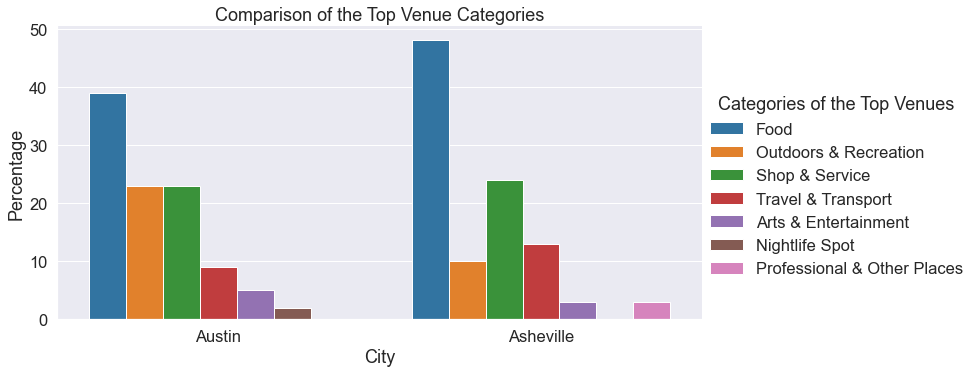

In [30]:
# Plot a chart comparing the top venue categories of each city by percentage of prevalence:
merged_df = sns.catplot(x="City", 
                        y='VenuePercentage', 
                        hue="TopCategory", 
                        kind="bar", 
                        data=merged_TopCatCount,
                        aspect=2,
                        palette=sns.color_palette("tab10")
                       )
merged_df.set(title='Comparison of the Top Venue Categories')
merged_df._legend.set_title('Categories of the Top Venues')
merged_df.set_ylabels(label='Percentage')
plt.show()
plt.close()

The above chart confirms that both cities share similar venue categories but it also shows us which city has a higher percentage of each venue category.

We can further explore our city comparisons by plotting for each of the venue categories found for each city. This will provide us with more details about the types of venues found and sheds more light on what a tourist can expect should they visit one of the cities. 

**Please note** that the venue types below represent the top most popular venues, and the absence of a venue type does not indicate that the city does not have such a venue, it merely indicates that the said venue was not ranked highest among the other venues in its neighborhood.

In [31]:
merged_TopCatCount.TopCategory.unique()

array(['Food', 'Outdoors & Recreation', 'Shop & Service',
       'Travel & Transport', 'Arts & Entertainment', 'Nightlife Spot',
       'Professional & Other Places'], dtype=object)

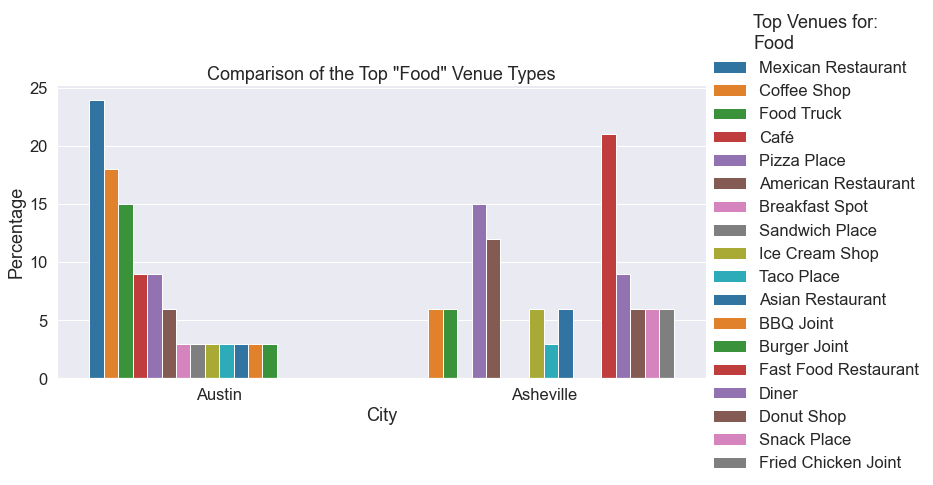

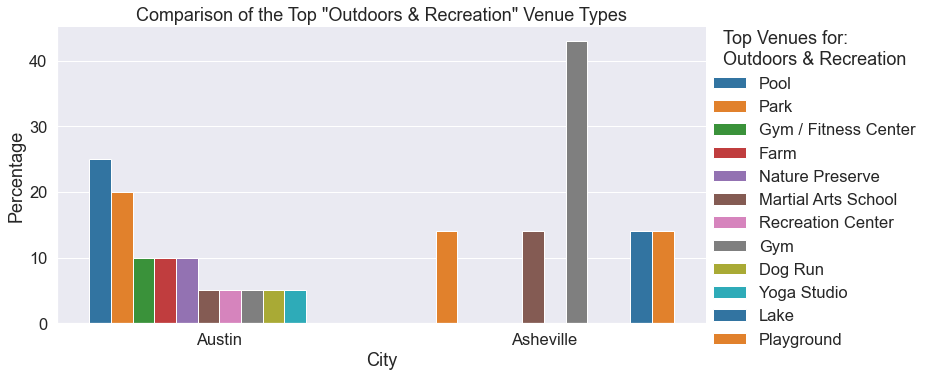

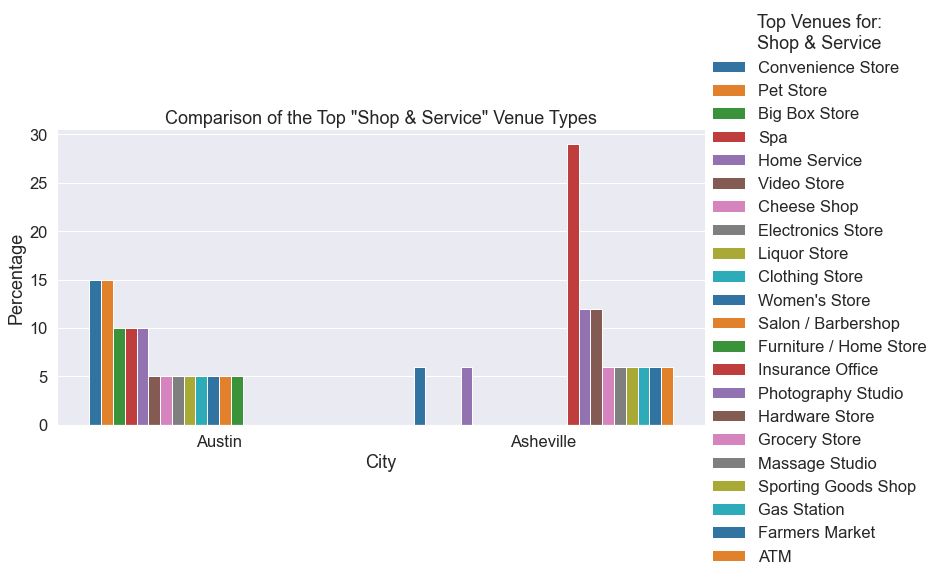

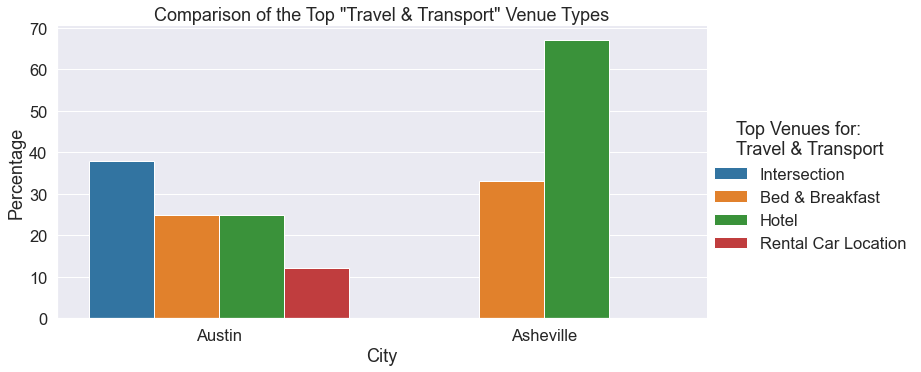

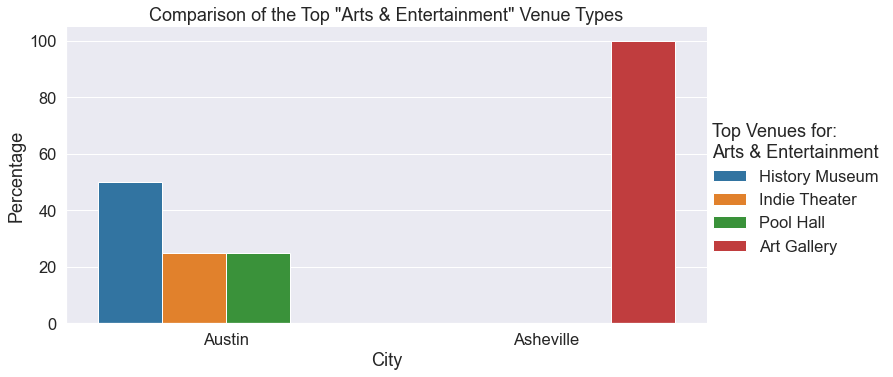

In [32]:
# Plot the top five venue categories for both cities:
top_venues = list(merged_TopCatCount.TopCategory.unique())
for top_cat in top_venues[:5]:
    TopVenues(aust_top_sorted, ash_top_sorted, top_cat)

## Results and Discussion <a name="results"></a>

Our analysis shows that although Austin and Asheville share similar popular venue categories, they differ in the concentration/percentage when compared to the total number of neighborhoods. 

When examining the percentages of the top most popular venue categories, we see that Asheville has more food venues rated as number one most popular per neighborhood than Austin. It also has a slightly higher percentage of top-rated venues in the "Shop & Service" field and a significant lead with regards to "Travel & Transport" venues. 

Austin's "Food" and "Shop & Service" venues are not as highly rated as that of Asheville, however, it does reign over Asheville when it comes to "Outdoors & Recreation" venues.

When we examine the plots for each of the top five venue categories for both cities ('Food', 'Outdoors & Recreation', 'Shop & Service', 'Travel & Transport', 'Arts & Entertainment'), we see in greater detail the different types of venues that fall under those categories and have a better understanding of what types of venues one could seek should they visit that city.

When comparing the "Arts & Entertainment" for both cities, we see that Austin has almost double the venues that are rated highly, but at a closer look, we see that Austin's advantage is in museums, indie theaters, and pool halls, while Asheville excels in art galleries.


## Conclusion <a name="conclusion"></a>

The purpose of this project was to compare the most popular venue categories and their respective venue types in both Austin, TX and Asheville, NC so that a prospective tourist will be able to make an educated decision as to which city they would like to visit based off of their own personal preferences.

Both cities have much in common, making it difficult for a tourist to choose between them. My project sheds light on the differences between the two cities by identifying the number one most highly rated venue for each neighborhood, along with the category it belongs to, and displaying these differences in easily understandable side-by-side graphs.

The final decision regarding which city to visit is left up to the prospective tourist/user to decide.
